In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from data.mix_gaussian import MixedGaussian
import minee

In [2]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

In [3]:
d = 2  # d is the dimension of X and Y. The dimension of joint mix-gaussian distribution is 2*d

rho = 0.9
sample_size = 400

X = np.zeros((sample_size, d))
Y = np.zeros((sample_size, d))

mg = MixedGaussian(sample_size=sample_size, rho1=rho, rho2=-rho)

hx, hy, hxy, mi = mg.ground_truth

"""
Splitting the 2-d Mix-Gaussian data into 2 components, and assign them to X and Y respectively. 
Generate 2-d Mix-Gaussian data from the same distribution and repeat this step for d times. 
(X,Y) is a mixed gaussian distribution; but X and Y are not.
"""
for i in range(d):
    data = mg.data
    X[:, i] = data[:, 0]
    Y[:, i] = data[:, 1]

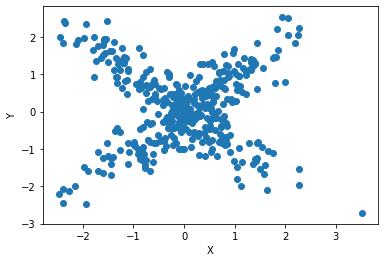

In [4]:
plt.figure()
plt.scatter(X[:, 0], Y[:, 0])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [5]:
# Ground truth of entropy of mixed gaussian distribution (X,Y)
# As the 2-d mix-gaussian data is generated independently, the entropy of (X, Y) is d times 
# the entropy of the 2-d mix-gaussian data.
h_xy = hxy * d
hx = hx * d
hy = hy * d

MI = mi * d

data = np.append(X, Y, axis=1)
# The cross entropy of uniform referance distribution 
ref_entropy_XY = minee._uniform_sample_entropy(data)

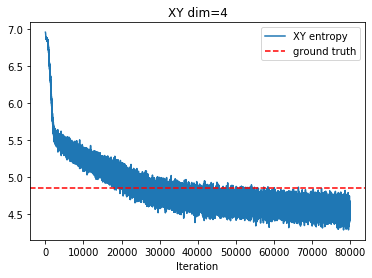

In [7]:
# -------------------------- Training ----------------------------- #
# Using Neural Network to estimate the entropy of the generated Gaussian distribution

batch_size = 100
lr = 1e-4
ref_batch_factor = 10  


NN = minee.MINEE(torch.Tensor(X), torch.Tensor(Y), batch_size=batch_size,ref_batch_factor=ref_batch_factor,lr=lr)

num_iteration = 80000

entropy_XY = []
dXY_list = []


for i in range(num_iteration):
    NN.step()
    dXY, dX, dY = NN.forward()
    entropy_XY.append(ref_entropy_XY - dXY)
    dXY_list.append(dXY)


In [ ]:
ma_rate = 0.01            # rate of moving average
entropy_list = entropy_XY.copy()    # see also the estimate() member function of MINE
for i in range(1,len(entropy_list)):
    entropy_list[i] = (1-ma_rate) * entropy_list[i-1] + ma_rate * entropy_list[i]

In [ ]:
plt.figure()
plt.plot(entropy_list, label='XY entropy')
plt.axhline(h_xy, label='ground truth', linestyle='--', color='red')
plt.xlabel('Iteration')
plt.title('XY dim=%d' % (2 * d))
plt.legend()
plt.savefig("./results/minee/dim=%d learnrate=%f.png" % (2 * d, lr))
plt.show()